In [126]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.ensemble import IsolationForest

In [61]:
X, Y = make_blobs(n_samples=200, centers=2, n_features=2, cluster_std=0.4, random_state=0)

In [129]:
class ExNode():
    def __init__(self, size):
        self.size = size
    
    def is_leaf(self) -> bool:
        return True


class InNode():
    def __init__(self, left, right, split_attr, split_value):
        self.left = left
        self.right = right
        self.split_attr = split_attr
        self.split_value = split_value
    
    def is_leaf(self) -> bool:
        return False


class IForest():
    def __init__(self, n_trees: int = 100, phai: int = 128, max_height: None = None) -> None:
        self.n_trees = n_trees
        self.phai = phai
        self.max_height = max_height
        if max_height is None:
            self.max_height = np.log2(phai)
        self.forest: List[InNode or ExNode] = []


    def _itree(self, X_sample: np.ndarray, e: int) -> InNode or ExNode:
        '''
        X_sample: sample data
        e: current tree height
        max_height: height limit
        '''
        if e >= self.max_height or X_sample.shape[0] <= 1:
            return ExNode(X_sample.shape[0])
        
        # Randomly select a feature
        q = np.random.choice(X_sample.shape[1])
        # Randomly select a split point
        p = np.random.choice(X_sample[:, q])

        X_left = X_sample[X_sample[:, q] < p]
        X_right = X_sample[X_sample[:, q] >= p]

        return InNode(left=self._itree(X_left, e+1), right=self._itree(X_right, e+1), split_attr=q, split_value=p)


    def fit(self, X):
        for _ in range(self.n_trees):
            X_sample = X[np.random.choice(X.shape[0], self.phai, replace=False)]
            tree = self._itree(X_sample, 0)
            self.forest.append(tree)


    def _harmonic_number(self, i):
        return np.log(i) + 0.5772156649


    def _normalize_path_length(self, n):
        '''
        引数nに対して、平均的に期待されるPathLengthを計算する
        '''
        if n <= 1:
            return 0
        return 2 * self._harmonic_number(n-1) - (2 * (n-1) / n)


    def _path_length(self, x, node=None, i_tree=None, e=0) -> int:
        '''
        外部からの呼び出し時は、`i_tree`で対象とする木を指定する
        内部からの呼び出し時は、`node`で対象とするノードを指定する
        '''
        if node is None and i_tree is None:
            raise ValueError('node or i_tree must be specified')
        if node is None:
            target_tree = self.forest[i_tree]
            node = target_tree

        if node.is_leaf():
            # 終端ノードに含まれるインスタンス数を考慮する
            # より多くのデータポイントが含まれていれば、未構築の部分木が多いと判断し、PathLengthを大きくする
            return e + self._normalize_path_length(node.size)

        feat = node.split_attr
        if x[feat] < node.split_value:
            return self._path_length(x, node.left, e+1)
        elif x[feat] >= node.split_value:
            return self._path_length(x, node.right, e+1)
    
    def anomaly_score(self, X, contamination=0.1):
        E = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            expected = np.zeros(len(self.forest))
            for i_tree in range(len(self.forest)):
                expected[i_tree] = self._path_length(x, i_tree=i_tree)

            # 全ての木に対するPathLengthの平均値を、各データポイントごとに計算
            E[i] = np.mean(expected)

        scores = 2 ** (-E / self._normalize_path_length(self.phai)) # 各木のデータポイント数（phai）で正規化する
        offset = np.percentile(scores, 100 * (1 - contamination))
        return np.where(scores > offset, -1, 1)

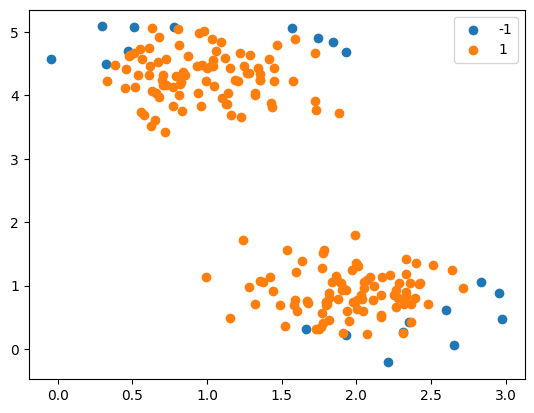

In [130]:
iforest = IForest()
iforest.fit(X)
labels = iforest.anomaly_score(X, contamination=0.1)
unique_labels = np.unique(labels)
for label in unique_labels:
    plt.scatter(X[labels == label, 0], X[labels == label, 1], label=label)
plt.legend()

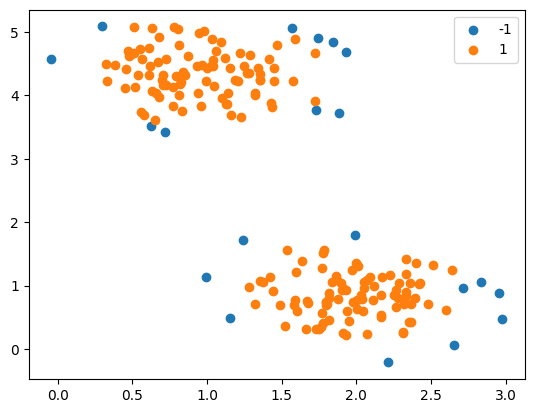

In [131]:
clf = IsolationForest(contamination=0.1).fit(X)
labels = clf.predict(X)
unique_labels = np.unique(labels)
for label in unique_labels:
    plt.scatter(X[labels == label, 0], X[labels == label, 1], label=label)
plt.legend()